---
title: "Instrumental variable analysis with a binary outcome"
mathjax: true
toc: true
toc_sticky: true
categories: [data science, statistics]
---

Here is an additional post on instrumental variable (IV) analysis. This follows an exercise where I employed two methods of IV analysis, [comparing a Bayesian approach with two-stage least squares (2SLS)](https://benslack19.github.io/data%20science/statistics/iv-pymc-sm/). My motivation for these posts is to have a better understanding, ultimately, of Mendelian randomization. The context in which I ultimately want to apply it to is a disease outcome, which is binary. In this post, I explore the Bayesian approach of IV analysis towards a binary outcome.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import scipy.stats as stats
import seaborn as sns
from scipy.special import expit
from utils import draw_causal_graph, standardize

In [2]:
RANDOM_SEED = 73
np.random.seed(RANDOM_SEED)
sns.set_context("talk")
sns.set_palette("colorblind")
cb_palette = sns.color_palette()

Notes
- check p per subject
- model, binary outcome, variable n

# Causal graph of example dataset with binary outcome

We'll return to the wages and education example from Chapter 14 of Statistical Rethinking. However, instead of using wages as our outcome, we'll tweak this by creating a binary outcome from wages, which I'll refer to as $R$ for "rich". The causal diagram will look the same as a traditional IV setup.

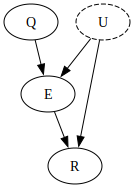

In [3]:
draw_causal_graph(
    edge_list=[("Q", "E"), ("U", "E"), ("U", "R"), ("E", "R")],
    node_props={"U": {"style": "dashed"}},
    graph_direction="TD",
)

Per usual, we'll use this to generate a simulated dataset. We'll use the same code but this time derive `R` from `W`. The rationale being those with higher wages are more likely to be rich. We’ll still making the influence of education on wages (`bEW_sim`) equal to 0. We'll want to get this value back in our statistical models, even though we'll be using `R` as our ultimate outcome variable.

A key conceptual point is use of a logit link function to produce `R` from `W`.  Additionally, we'll make use of a [binomial generalized linear model](https://benslack19.github.io/data%20science/statistics/multilevel_modeling_01/).

In [52]:
def generate_data(num_subjects, n_binomial_param) -> pd.DataFrame:
    """Generate simulated data.

    Parameters
    ----------
    num_subjects
        Number of subjects/rows in data
    n_binomial_param
        Number of "observations" for each subject;
        a parameter in the binomial GLM

    Returns
    -------
    sim_df
        pd.DataFrame

    """

    bEW_sim = 0

    U_sim = np.random.normal(size=num_subjects)
    Q_sim = np.random.randint(1, 5, size=num_subjects)
    E_sim = np.random.normal(loc=U_sim + Q_sim, size=num_subjects)
    W_sim = np.random.normal(loc=U_sim + bEW_sim * E_sim, size=num_subjects)
    sim_df = pd.DataFrame.from_dict(
        {"W": standardize(W_sim), "E": standardize(E_sim), "Q": standardize(Q_sim)}
    )

    # Use of link functions to generate R
    index_val = sim_df.index.values
    sim_df["R"] = stats.binom.rvs(n=n_binomial_param, p=expit(W_sim))
    sim_df["R_size"] = n_binomial_param

    return sim_df


dat_sim = generate_data(num_subjects=500, n_binomial_param=2)
dat_sim.head()

,W,E,Q,R,R_size
0,-1.327032,-0.600469,0.453638,1,2
1,-0.108554,-0.159673,-1.318387,0,2
2,-0.908108,1.066808,0.453638,2,2
3,-2.187143,-2.856829,-1.318387,0,2
4,0.044873,-0.024763,-0.432374,1,2


As usual, visualizing the data can give us some insight into how the data *appears* and where confounds may mislead. We know that `Q` is a cause of `E` and therefore the association we see is reflective of causation. The bottom-left figure `W` vs. `R` is a logit transformation of the former into the latter. However, both the plots in the right column are a result of the confound `U`. It is driving the relationship between `E` and `W` and therefore we also see an association between `E` and `R`.

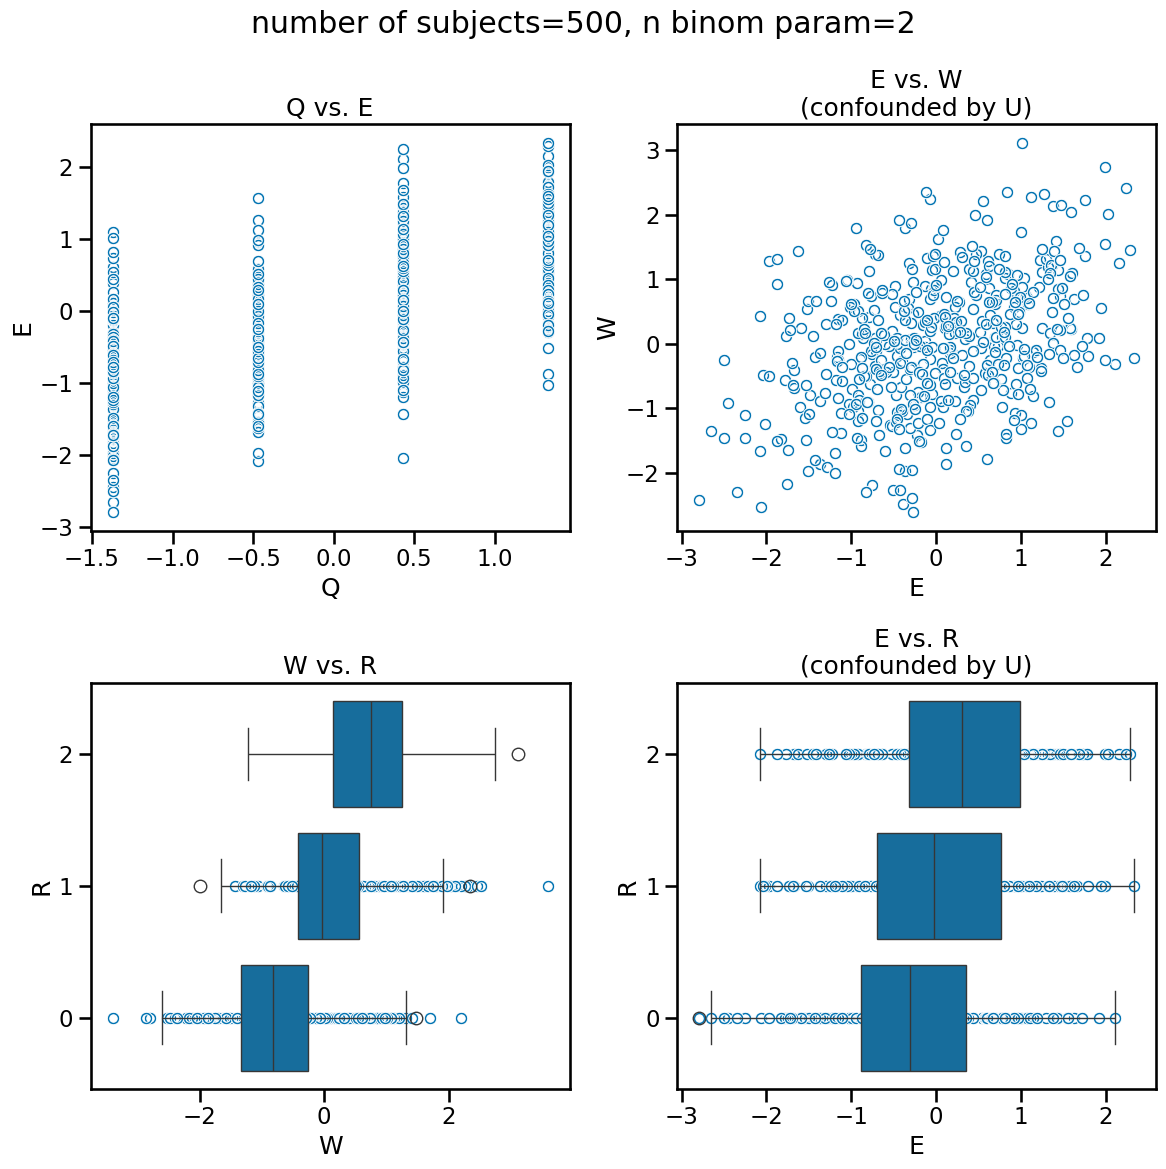

In [43]:
def plot_variable_relationships(sim_df, title):
    f, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(12, 12))

    sns.scatterplot(data=sim_df, x="Q", y="E", marker=r"$\circ$", ax=ax0)
    ax0.set_title("Q vs. E")

    sns.scatterplot(data=sim_df, x="E", y="W", marker=r"$\circ$", ax=ax1)
    ax1.set_title("E vs. W\n(confounded by U)")

    sns.boxplot(data=sim_df, x="W", y="R", orient="h", color=cb_palette[0], ax=ax2)
    sns.scatterplot(data=dat_sim_n1, x="W", y="R", marker=r"$\circ$", ax=ax2)
    ax2.invert_yaxis()
    ax2.set_title("W vs. R")

    sns.boxplot(data=sim_df, x="E", y="R", orient="h", color=cb_palette[0], ax=ax3)
    sns.scatterplot(data=sim_df, x="E", y="R", marker=r"$\circ$", ax=ax3)
    ax3.invert_yaxis()
    ax3.set_title("E vs. R\n(confounded by U)")

    f.suptitle(title)
    f.tight_layout()


plot_variable_relationships(dat_sim, "number of subjects=500, n binom param=2")

# Bayesian model with binary outcome

We'll use the Bayesian approach to run our inferential model. Again, the important thing is the link function to get our count output.

$$ R_i \sim \text{Binomial}(n_i, p_i) $$

$$ \text{logit}(p_i) = W_i $$

$$ \left( \begin{array}{c} W_i \\ {E_i} \end{array} \right) \sim \text{MVNormal} \left( \begin{array}{c}{\mu_{W_i}}  \\ {\mu_{E_i} } \end{array} , \textbf{S} \right)    $$

$$ \mu_{W_i} = \alpha_W + \beta_{EW} W_i  $$

$$ \mu_{E_i} = \alpha_E + \beta_{QE} E_i  $$

$$ \alpha_W, \alpha_E \sim \text{Normal}(0, 0.2) $$

$$ \beta_{EW}, \beta_{QE} \sim \text{Normal}(0, 1.5) $$

$$
\textbf{S} = \begin{pmatrix} \sigma_{W}^2 & \rho\sigma_{W}\sigma_{E} \\ 
                \rho\sigma_{W}\sigma_{E} & \sigma_{E}^2 \end{pmatrix} = \begin{pmatrix} \sigma_{P} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix} \textbf{R} \begin{pmatrix} \sigma_{W} & 0 \\ 0 & \sigma_{E} \end{pmatrix}
$$

$$
\textbf{R} \sim \text{LKJCorr}(2)
$$

In [18]:
def run_bayesian_iv_model_binary(data_df):
    """Model for education/rich binary outcome.

    Parameters
    ----------
    data_df
        Generated dataset

    Returns
    -------
    :
        pymc idata object
    """

    index_vals = data_df.index.values

    with pm.Model() as model:
        aW = pm.Normal("aW", 0.0, 0.2)
        aE = pm.Normal("aE", 0.0, 0.2)
        bEW = pm.Normal("bEW", 0.0, 0.5)
        bQE = pm.Normal("bQE", 0.0, 0.5)

        muW = pm.Deterministic("muW", aW + bEW * data_df.E.values)
        muE = pm.Deterministic("muE", aE + bQE * data_df.Q.values)

        chol, _, _ = pm.LKJCholeskyCov(
            "chol_cov", n=2, eta=2, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
        )

        # multivariate regression
        MU = pt.stack([muW, muE]).T
        YY_obs = pm.Data("YY_obs", data_df[["R", "E"]].values)
        YY = pm.MvNormal("YY", mu=MU, chol=chol, observed=YY_obs)

        # link function
        p = pm.Deterministic("p", pm.math.invlogit(YY[index_vals, 0]))
        R = pm.Binomial("R", n=data_df["R_size"], p=p, observed=data_df["R"])

        idata = pm.sample(1000, random_seed=RANDOM_SEED, target_accept=0.95)
        idata.rename({"chol_cov_corr": "Rho", "chol_cov_stds": "Sigma"}, inplace=True)

    return idata

In [13]:
idata_14_6_logit = run_bayesian_iv_model_binary(dat_sim)

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━  32% 0:00:17 / 0:00:10

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.


Text(0.5, 1.0, 'm14.6 with logistic link')

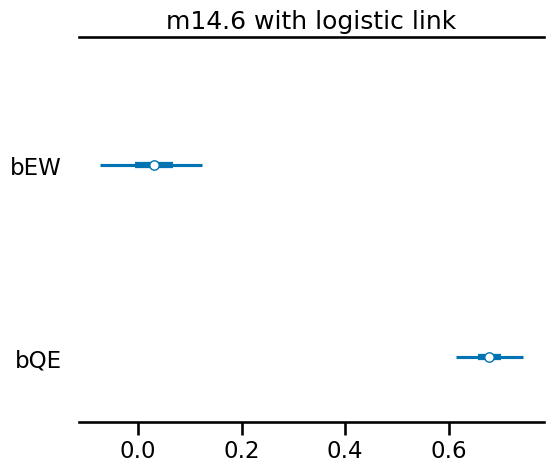

In [14]:
f, ax0 = plt.subplots(1, 1, figsize=(6, 5), sharex=True)
az.plot_forest(idata_14_6_logit, var_names=["bEW", "bQE"], combined=True, ax=ax0)
ax0.set_title("m14.6 with logistic link")

As you can see, we get coefficients as the original [wages and education example](https://benslack19.github.io/data%20science/statistics/iv-pymc-sm/#comparison-of-estimates-between-approaches).

# Experimenting with number of subjects and the binomial parameter

A practical question we might have in a real world scenario is how many subjects we might need and how many observations we might want per person. Generally, more people will give us more power for our estimate. We can run experiments to help us understand how these parameters influence the credible interval of our estimate.

In [198]:
num_subjects_list = [25, 100, 200, 500]
n_binomial_param_list = [1, 2, 5]

In [57]:
def format_summary_table(
    idata, num_subjects, n_binomial_param, var_names=["bEW", "bQE"]
):
    df = (
        az.summary(idata, var_names=var_names)
        .assign(num_subjects=num_subjects)
        .assign(n_binomial_param=n_binomial_param)
    )
    return df

In [63]:
df_summary = list()
for num_subjects in num_subjects_list:
    for n_binomial_param in n_binomial_param_list:
        print(
            f"Running {num_subjects} num_subjects, {n_binomial_param} n_binomial_param..."
        )
        dat_sim_expt = generate_data(
            num_subjects=num_subjects, n_binomial_param=n_binomial_param
        )
        idata_14_6_logit_expt = run_bayesian_iv_model_binary(dat_sim_expt)
        df_expt_summary = format_summary_table(
            idata_14_6_logit_expt,
            num_subjects=num_subjects,
            n_binomial_param=n_binomial_param,
        )
        df_summary.append(df_expt_summary)

print("Done with experiment")
df_summary = pd.concat(df_summary)
df_summary

Running 25 num_subjects, 1 n_binomial_param...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aW, aE, bEW, bQE, chol_cov]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 124 seconds.


Running 25 num_subjects, 2 n_binomial_param...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aW, aE, bEW, bQE, chol_cov]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 89 seconds.


Running 25 num_subjects, 5 n_binomial_param...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aW, aE, bEW, bQE, chol_cov]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 151 seconds.


Running 100 num_subjects, 1 n_binomial_param...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aW, aE, bEW, bQE, chol_cov]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 120 seconds.


Running 100 num_subjects, 2 n_binomial_param...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aW, aE, bEW, bQE, chol_cov]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 94 seconds.


Running 100 num_subjects, 5 n_binomial_param...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aW, aE, bEW, bQE, chol_cov]


Output()

/Users/benlacar/opt/anaconda3/envs/pymc_env_2405/lib/python3.12/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/Users/benlacar/opt/anaconda3/envs/pymc_env_2405/lib/python3.12/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 100 seconds.


Running 200 num_subjects, 1 n_binomial_param...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aW, aE, bEW, bQE, chol_cov]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 120 seconds.


Running 200 num_subjects, 2 n_binomial_param...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aW, aE, bEW, bQE, chol_cov]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 149 seconds.


Running 200 num_subjects, 5 n_binomial_param...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aW, aE, bEW, bQE, chol_cov]


Output()

/Users/benlacar/opt/anaconda3/envs/pymc_env_2405/lib/python3.12/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/Users/benlacar/opt/anaconda3/envs/pymc_env_2405/lib/python3.12/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.


Running 500 num_subjects, 1 n_binomial_param...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aW, aE, bEW, bQE, chol_cov]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.


Running 500 num_subjects, 2 n_binomial_param...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aW, aE, bEW, bQE, chol_cov]


Output()

/Users/benlacar/opt/anaconda3/envs/pymc_env_2405/lib/python3.12/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 148 seconds.


Running 500 num_subjects, 5 n_binomial_param...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aW, aE, bEW, bQE, chol_cov]


Output()

/Users/benlacar/opt/anaconda3/envs/pymc_env_2405/lib/python3.12/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/Users/benlacar/opt/anaconda3/envs/pymc_env_2405/lib/python3.12/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/Users/benlacar/opt/anaconda3/envs/pymc_env_2405/lib/python3.12/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 94 seconds.


Done with experiment


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,num_subjects,n_binomial_param
bEW,0.254,0.163,-0.067,0.556,0.005,0.003,1330.0,1345.0,1.0,25,1
bQE,0.430,0.174,0.087,0.741,0.003,0.002,3144.0,2492.0,1.0,25,1
bEW,0.075,0.290,-0.491,0.606,0.007,0.005,1558.0,1779.0,1.0,25,2
bQE,0.572,0.158,0.256,0.841,0.003,0.002,2945.0,2536.0,1.0,25,2
bEW,-0.118,0.447,-1.018,0.664,0.009,0.007,2226.0,2858.0,1.0,25,5
bQE,0.503,0.153,0.203,0.777,0.003,0.002,2942.0,2430.0,1.0,25,5
bEW,0.069,0.077,-0.078,0.212,0.002,0.001,2062.0,1784.0,1.0,100,1
bQE,0.631,0.078,0.491,0.780,0.001,0.001,4154.0,3071.0,1.0,100,1
bEW,0.097,0.134,-0.157,0.339,0.003,0.002,1835.0,1786.0,1.0,100,2
bQE,0.589,0.079,0.442,0.736,0.001,0.001,2903.0,2622.0,1.0,100,2


## Results of experiments with generated data parameters

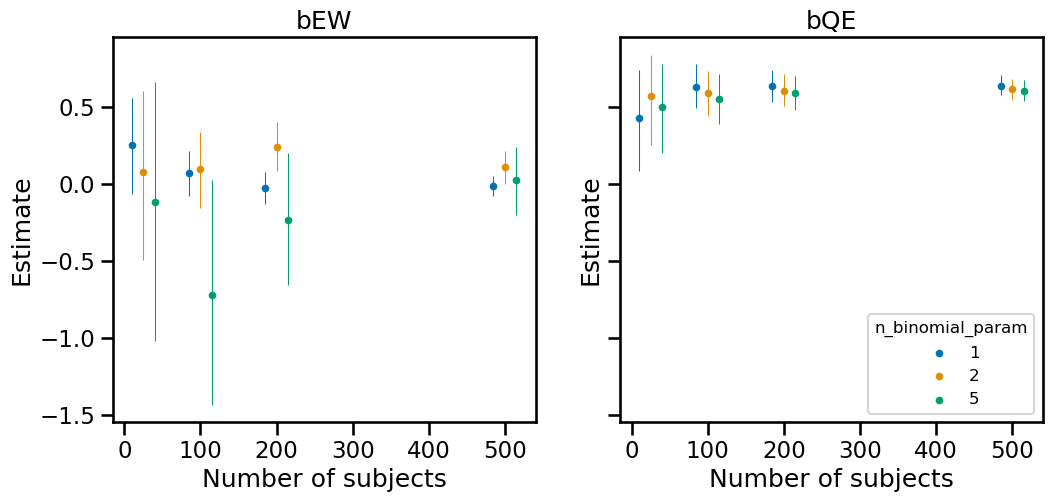

In [195]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

def plot_mean_and_ci(coefficient, ax):
    x_shifts = [-15, 0, 15]
    n_binomial_param_list = [1, 2, 5]
    colors = cb_palette[0:3]
    for n_binom, x_shift, color in zip(n_binomial_param_list, x_shifts, colors):
        df = (
            df_summary.reset_index(names="coefficient")
            .query("coefficient==@coefficient")
            .query("n_binomial_param==@n_binom")
        )
        ax.scatter(df["num_subjects"]+x_shift, df["mean"], facecolors=None, edgecolor=color, s=2**4, label=n_binom)
        ax.vlines(x=df["num_subjects"]+x_shift, ymin=df["hdi_3%"], ymax=df["hdi_97%"], linewidth=0.75, color=color)
    ax.set_title(coefficient)
    ax.set(
        xlabel="Number of subjects",
        ylabel="Estimate"
        
    )
    if coefficient == "bQE":    
        ax.legend(title='n_binomial_param', title_fontsize=12, fontsize=12, loc='lower right')

plot_mean_and_ci("bEW", ax0)
plot_mean_and_ci("bQE", ax1)


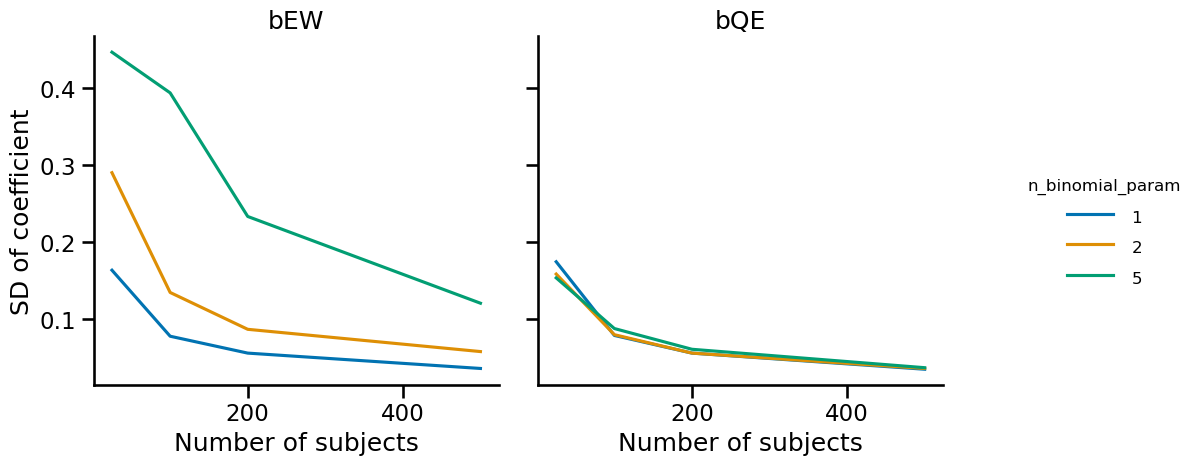

In [197]:
g = sns.relplot(
    data=df_summary.reset_index(names="coefficient"),
    x="num_subjects",
    y="sd",
    hue="n_binomial_param",
    hue_order = [1,2,5],
    col="coefficient",
    palette=cb_palette[0:3],
    kind='line'
)

g.set_titles(col_template="{col_name}")
g.set_axis_labels(x_var="Number of subjects", y_var="SD of coefficient")
plt.setp(g._legend.get_texts(), fontsize='12')
plt.setp(g._legend.get_title(), fontsize='12');

First, it makes sense that the variability of `bQE` is not affected by the binomial parameter since this coefficient is not dependent on the logit transformation. The variability of the `bEW` decreases with the number of subjects, as one might intuit. But I didn't necessarily expect that a higher $n$ as a binomial parameter would lead to higher variability.

# Summary and acknowledgements

My motivation for this post was understanding how to implement IV analysis with a binary outcome. I also ran an experiment to determine appropriate sample sizes. Some of the coding implementation was tricky for me initially. Thanks to [the man](https://xcelab.net/rm/) himself for providing some [help](https://x.com/rlmcelreath/status/1798972577387339782).

In [199]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Wed Jun 12 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.24.0

pymc      : 5.15.0
matplotlib: 3.8.4
scipy     : 1.13.0
seaborn   : 0.13.2
numpy     : 1.26.4
pandas    : 2.2.2
arviz     : 0.18.0
pytensor  : 2.20.0

Watermark: 2.4.3

